In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, 'utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 1 TB / available: 1 TB / percent used: 0.5 %


In [2]:
path = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly'

In [3]:
# For parallelisation
from dask.distributed import Client
client = Client(n_workers=12, threads_per_worker=1, memory_limit='80GB')
client

Client Scheduler: tcp://127.0.0.1:43839 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 960.00 GB


In [15]:
client.close()

In [4]:
ds = xr.open_mfdataset(path+'/*.nc', parallel=True, chunks={'time': 1, 'lat': 18000, 'lon': 36000})
ds

,Array,Chunk
Bytes,1.30 TB,5.18 GB
Shape,"(251, 18000, 36000)","(1, 18000, 36000)"
Count,523 Tasks,251 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.30 TB,5.18 GB
Shape,"(251, 18000, 36000)","(1, 18000, 36000)"
Count,523 Tasks,251 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


# /!\ Masks of water and ice are not set for the first 2 years /!\
(same mask for all years, so you can take mask[2]

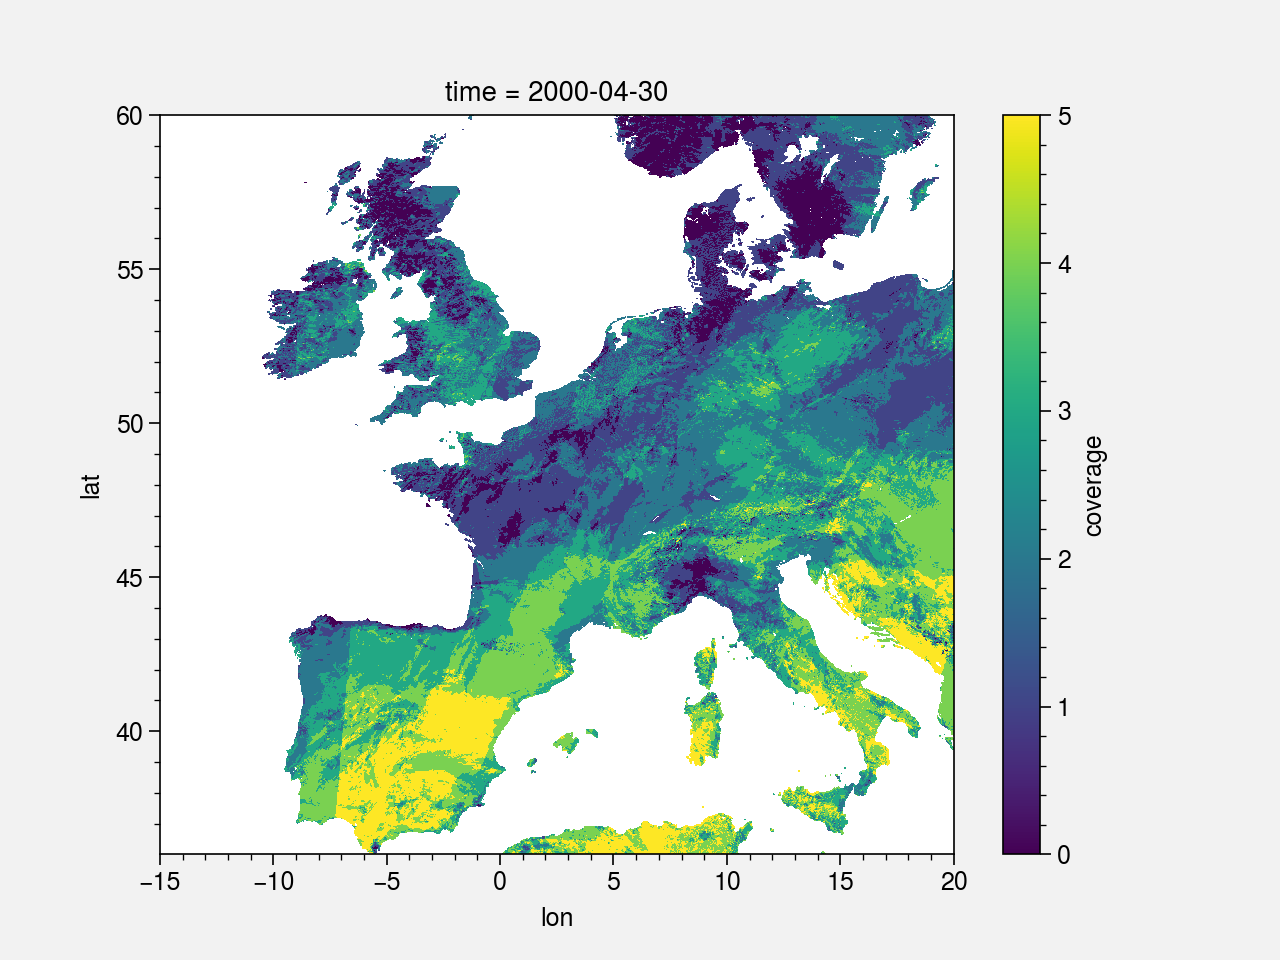

In [5]:
ds.coverage[0].where(ds.mask_water[2] != 210).where(ds.mask_ice[2] != 215).sel(lat=slice(36,60), lon=slice(-15, 20)).plot()

In [6]:
ds.coverage

,Array,Chunk
Bytes,1.30 TB,5.18 GB
Shape,"(251, 18000, 36000)","(1, 18000, 36000)"
Count,523 Tasks,251 Chunks
Type,float64,numpy.ndarray


In [6]:
coverage = ds.coverage.where(ds.mask_water[2] != 210).where(ds.mask_ice[2] != 215).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat','lon'))
coverage.load()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


<xarray.DataArray (time: 251)>
array([ 2.17488822, 14.49480606, 13.48569481, 15.91899646, 15.56947473,
       17.00453127,  9.8887859 , 16.15660842, 14.99303823, 13.73534931,
       13.05417844, 13.55450281, 12.71832414, 14.76565367, 15.22501057,
       16.36379273,  7.79347884, 15.5519346 , 17.45328894, 16.29554069,
       15.78900855, 14.14034303, 13.12934782, 13.43660103, 13.05700513,
       10.5799085 , 14.53541583, 17.09701505, 16.88352743, 17.5741064 ,
       17.06896051, 16.31698605, 15.7102378 , 14.40786953, 13.12612545,
       13.34647176, 12.29994689, 14.80922561, 15.21178136, 16.89290024,
       16.48576831, 17.38251148, 16.90889195, 16.28962993, 16.1432649 ,
       14.20872165,  9.84091681, 12.71964544, 13.17533555, 15.04116099,
       15.25400811, 16.21209264, 16.69694672, 17.3028614 , 17.07480723,
       16.49331841, 15.99731309, 14.13775947, 13.39924777, 13.19558658,
       12.99881485, 14.99087525, 15.95341619, 16.82663612, 16.47668961,
       17.57240635, 17.0053388 , 16.67133206, 16.67864376, 14.34479115,
       13.42480841, 13.00933531, 12.69879655, 14.73294777, 14.97992053,
       16.77106042, 16.79867379, 17.66845211, 16.540039  , 16.76643518,
       15.73040563, 14.13002214, 13.01972284, 13.5120355 , 13.4511537 ,
       15.44190901, 15.80149665, 17.06734227, 16.54036076, 17.25094527,
       17.06586506, 16.60694768, 16.49025964, 15.00558635, 13.20102579,
       12.82968414, 13.47674898, 15.59109045, 15.61103732, 16.79079148,
...
       13.35854924, 13.02117058, 15.18685468, 15.71673917, 16.79698334,
       16.826864  , 17.04017504, 17.06821583, 16.10396798, 16.26195242,
       14.01735252, 13.66514758, 13.75858833, 12.5047623 , 15.27861574,
       15.35249456, 16.3578561 , 16.78008706, 17.44261062, 17.43736056,
       16.30868109, 15.86499028, 13.94935118, 13.35465882, 13.39244414,
       13.21474177, 15.06159493, 15.48968069, 16.66873668, 16.99241737,
       17.26056207, 17.30841664, 16.75251776, 16.02921679, 14.20082689,
       13.29234286, 13.25324608,  9.92749062, 14.58881543, 15.32773522,
       16.21599558, 16.8595148 , 17.29405174, 17.55440339, 16.47450382,
       15.86413299, 14.53808001, 13.3761855 , 13.35492465, 13.06316962,
       15.48179034, 14.9439309 , 16.72421819, 16.88209667, 17.88842666,
       17.30874351, 16.43930388, 16.35648992, 14.28234435, 13.54937524,
       13.81744345, 12.48155373, 15.1777974 , 15.68763053, 17.06206311,
       16.87261293, 17.49044273, 17.10464675, 16.59431521, 15.94008276,
       13.58286049, 13.1443443 , 13.40855751, 12.94558396, 15.53594575,
       15.58441802, 16.52565273, 17.15267655, 17.5361665 , 17.37156043,
       16.73258536, 15.86200589, 14.22805696, 13.57318975, 12.99433165,
       13.67286749, 14.98306129, 15.92726419, 17.16563393, 16.99029298,
       17.23183593, 17.22828708, 16.80338176, 16.59865485, 14.20995305,
       13.02586569])
Coordinates:
  * time     (time) datetime64[ns] 2000-02-29 2000-03-31 ... 2020-12-31

In [7]:
coverage_interp = ds.coverage_interp.where(ds.mask_water[2] != 210).where(ds.mask_ice[2] != 215).weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat','lon'))
coverage_interp.load()

<xarray.DataArray (time: 251)>
array([ 3.16051725, 26.21410401, 26.21210155, 28.06762917, 26.78041707,
       27.53992433, 14.53655679, 26.92528754, 27.19784039, 24.46101263,
       23.08501272, 23.37164906, 22.94838073, 26.83008208, 26.7650227 ,
       28.33521837, 12.12023793, 24.56062323, 27.70096485, 27.19253489,
       27.40435562, 24.58305213, 23.41679509, 23.76164299, 23.11206918,
       19.39108705, 26.61954822, 28.40295249, 27.28042761, 27.9942136 ,
       27.6874032 , 27.22461705, 27.32182826, 24.77503564, 23.46240472,
       23.60883145, 22.89131473, 26.56196059, 26.96559762, 28.17450049,
       27.16098522, 27.78427226, 27.47043351, 27.1591807 , 27.54609062,
       24.84178103, 19.13667172, 23.26441088, 23.89329934, 26.62033202,
       27.24039072, 28.08921672, 27.3284662 , 28.05395514, 27.91314892,
       27.16705908, 27.53619953, 25.01768357, 23.85256779, 23.87781069,
       23.0915116 , 27.01760673, 27.19011382, 28.30255164, 27.2107523 ,
       27.84458325, 27.58698357, 27.48247412, 28.0112996 , 24.33787594,
       23.18864076, 23.52119245, 23.11053313, 26.63592027, 26.79339807,
       28.10163254, 27.39251574, 27.85900622, 27.67947325, 27.4862429 ,
       27.62175642, 24.30499816, 23.15266096, 23.5922425 , 23.44338972,
       27.0509812 , 27.36791374, 28.52508961, 27.09633633, 27.61794082,
       27.53342716, 26.98316335, 27.34916324, 25.08674956, 23.17049086,
       22.7658176 , 23.55188639, 27.02941919, 26.92032989, 28.11488098,
...
       23.45346232, 22.72139518, 26.94015141, 27.1347158 , 28.44498444,
       27.30953687, 27.5895233 , 27.5375744 , 26.80712971, 27.74291747,
       24.83642661, 23.81655938, 23.83036351, 21.98247645, 27.05916055,
       27.2157319 , 28.41779606, 27.22404818, 27.93024444, 27.7151106 ,
       27.24217602, 27.49356092, 24.84684543, 23.69338492, 23.90277089,
       23.41015846, 26.99064877, 27.04899994, 28.36602064, 27.31500447,
       27.96144486, 28.08902433, 27.5626788 , 27.75591961, 24.61386945,
       23.84797213, 23.96259488, 17.75152871, 26.62280685, 27.12401818,
       28.4255181 , 27.36310171, 27.74858174, 28.23175574, 27.2360627 ,
       26.8468131 , 24.89409294, 24.03376276, 23.69856544, 23.44374797,
       26.99901959, 26.94262239, 28.61071481, 27.36975255, 27.83622205,
       27.76504665, 27.08563354, 27.31582295, 24.44080986, 23.70497745,
       23.80537086, 23.01899441, 27.08842853, 26.95339603, 28.27887719,
       27.01645166, 27.49978399, 27.6813921 , 27.46459315, 27.59803881,
       24.25475685, 22.91120223, 23.57629387, 23.02345853, 27.53753864,
       27.2548334 , 28.31280706, 27.33476422, 27.82041588, 27.71439088,
       27.33340286, 27.27499888, 24.87805345, 23.69361563, 23.58956859,
       24.52806917, 27.10803077, 27.1485529 , 28.64890291, 27.18642891,
       27.66194868, 27.57961516, 27.13442591, 27.13553928, 24.19091112,
       21.91214049])
Coordinates:
  * time     (time) datetime64[ns] 2000-02-29 2000-03-31 ... 2020-12-31

## Replace NaN values by 0 corresponding to the missing data from 1994-11 to 1995-01

### Initial time coverage

In [7]:
np.count_nonzero(np.isnan(coverage))

0

In [8]:
tot_num_days = (pd.to_datetime(ds.time[-1].values) - pd.to_datetime(ds.time[0].values)).days
coverage.sum('time')/tot_num_days*100

<xarray.DataArray ()>
array(50.2114356)

### Interp time coverage

In [8]:
np.count_nonzero(np.isnan(coverage_interp))

0

In [9]:
tot_num_days = (pd.to_datetime(ds.time[-1].values) - pd.to_datetime(ds.time[0].values)).days
coverage_interp.sum('time')/tot_num_days*100

<xarray.DataArray ()>
array(85.51209489)